In [2]:
import bayestorch as bt
from bayestorch import Parameter,Data,Variable,optimizing,vb,sampling,reset
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [3]:
from bayestorch.data.battle import friend_point,enemy_point,battle_point

In [18]:
friend_point1 = friend_point
friend_point0 = friend_point - np.array([0.25,0.25]) + (np.random.random(size=friend_point.shape)-0.5)

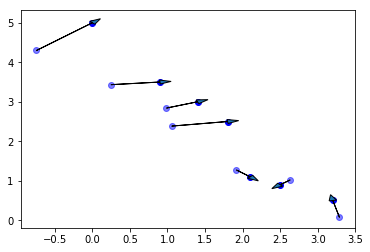

In [19]:
plt.scatter(friend_point0[:,0], friend_point0[:,1], color="blue",alpha=0.5)
plt.scatter(friend_point1[:,0], friend_point1[:,1], color="blue",alpha=1.0)
for i in range(friend_point0.shape[0]):
    plt.arrow(friend_point0[i,0], friend_point0[i,1], friend_point1[i,0] - friend_point0[i,0], friend_point1[i,1] - friend_point0[i,1],head_width=0.1)
plt.show()

正向模型是ally和enemy在$[0,1]$的时间中沿各自的两个点移动，关于移动距离限制可以作为一个先验，不过这里先不讨论。

然后在给定时间按当时双方分布所决定的battle分布采样特定数量个战役（这个时间和数量可以随机过程化，不过这里先不讨论）。
从而我们可以利用两倍数量的ally位置和带timestamp的战役与推断比之前模型两倍参数数量的模型。

它的一次实现类似这个样子：

In [21]:
timestamp = np.random.random(len(battle_point))

In [22]:
battle_point_time = np.c_[battle_point + np.c_[timestamp,timestamp], timestamp]

In [23]:
battle_point_time

array([[1.46398174, 4.98769867, 0.27179431],
       [1.81695751, 5.98223179, 0.43094789],
       [4.02926348, 3.89334641, 0.97902462],
       [1.25739415, 5.10616724, 0.18464922],
       [3.35229326, 4.86136031, 0.99866751],
       [2.05913947, 4.86020807, 0.81942011],
       [2.36629764, 3.39298856, 0.5787202 ],
       [1.64320791, 3.20659491, 0.15401003],
       [4.79713564, 0.78838733, 0.23180331],
       [4.37849897, 3.71113865, 0.13648585]])

In [36]:
enemy_point0 = enemy_point
enemy_point1 = enemy_point0 + np.array([0.5,0.5]) + (np.random.random(size=enemy_point0.shape)-0.5)

In [39]:
def plot_move(x,y,dx,dy,**kwargs):
    plt.scatter(x, y,alpha=0.5, **kwargs)
    plt.scatter(x+dx, y+dy, alpha=1.0, **kwargs)
    for i in range(x.shape[0]):
        plt.arrow(x[i], y[i], dx[i], dy[i],head_width=0.1)


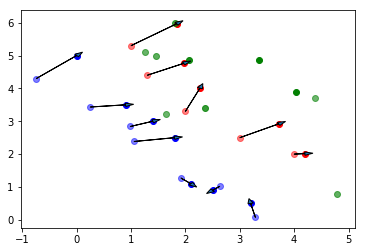

In [40]:
plot_move(friend_point0[:,0], friend_point0[:,1], friend_point1[:,0] - friend_point0[:,0], friend_point1[:,1] - friend_point0[:,1], color='blue')
plot_move(enemy_point0[:,0], enemy_point0[:,1], enemy_point1[:,0] - enemy_point0[:,0], enemy_point1[:,1] - enemy_point0[:,1], color='red')
for i in range(battle_point_time.shape[0]):
    plt.scatter(battle_point_time[i,0],battle_point_time[i,1],color='green',alpha=battle_point_time[i,2]*0.5+0.5)

也可以考虑知道0时对方位置，根据battle推断末时位置和知道末时位置推断0时位置（并不那么有用）的操作。
这里先考虑知道初时位置判定1时位置的操作。

In [41]:
# transformed data

_logPC = np.log([len(friend_point)/(len(friend_point)+len(enemy_point)),len(enemy_point)/(len(friend_point)+len(enemy_point))])


In [55]:
from bayestorch.distributions import norm_log_prob
from bayestorch.classifier import norm_naive_bayes_predict
from bayestorch.utils import GridSampler2d,cdist,soft_cut_ge,soft_cut_le

model = bt.core.current_model



In [54]:
# model

reset()

friend0 = Data(friend_point0)
friend1 = Data(friend_point1)
enemy0 = Data(enemy_point0)
enemy1 = Parameter(enemy_point0.copy())
battle = Data(battle_point[:,:2])
timestamp = Data(battle_point_time[:,2])
logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0



In [51]:
'''
def target():
    friend_enemy = torch.cat((friend, enemy),0)
    distance = cdist(battle, friend_enemy).min(dim=1)[0]
    

    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
    sd = Variable(torch.zeros(2,2))
    
    mu[0,:] = friend.mean(dim=0)
    mu[1,:] = enemy.mean(dim=0)
    sd[0,:] = friend.std(dim=0)
    sd[1,:] = enemy.std(dim=0)
    
    conflict = torch.exp(norm_naive_bayes_predict(battle, mu, sd, logPC)).prod(dim=1)
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    
    target= torch.sum(torch.log(p))
    return target
'''

'\ndef target():\n    friend_enemy = torch.cat((friend, enemy),0)\n    distance = cdist(battle, friend_enemy).min(dim=1)[0]\n    \n\n    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了\n    sd = Variable(torch.zeros(2,2))\n    \n    mu[0,:] = friend.mean(dim=0)\n    mu[1,:] = enemy.mean(dim=0)\n    sd[0,:] = friend.std(dim=0)\n    sd[1,:] = enemy.std(dim=0)\n    \n    conflict = torch.exp(norm_naive_bayes_predict(battle, mu, sd, logPC)).prod(dim=1)\n    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)\n    \n    target= torch.sum(torch.log(p))\n    return target\n'

In [71]:
def target():
    # 由于每个时点所涉及的mu,sd发生了变化所以不能像之前那样统一的处理，暂时也没看出显然的向量化写法
    target = Variable(torch.zeros(1))
    for i in range(battle_point.shape[0]):
        t = timestamp[i]
        friend = friend0*(1-t) + friend1*t
        enemy = enemy0*(1-t) + enemy1*t
        single_battle = torch.unsqueeze(battle[i],0) # 这个应该会退化为向量，不一定符合结果
        
        friend_enemy = torch.cat((friend, enemy), 0)
        distance = cdist(single_battle, friend_enemy).min(dim=1)[0]
        
        mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
        sd = Variable(torch.zeros(2,2))

        mu[0,:] = friend.mean(dim=0)
        mu[1,:] = enemy.mean(dim=0)
        sd[0,:] = friend.std(dim=0)
        sd[1,:] = enemy.std(dim=0)

        conflict = torch.exp(norm_naive_bayes_predict(single_battle, mu, sd, logPC)).prod(dim=1)
        p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)

        target+= torch.sum(torch.log(p))
    return target


In [72]:
res = vb(target)
res

(array([2.02568337, 5.54925299, 1.93185998, 3.89926634, 2.64537162,
        2.9652001 , 2.98674099, 1.38945968, 5.21951584, 5.76405529]),
 array([0.13893117, 0.29673661, 0.45878533, 0.46358693, 0.111828  ,
        0.14104197, 0.71557018, 0.94669159, 0.68178202, 0.56056387]))

In [79]:
def display_data():
    '''
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    plt.scatter(battle_point[:,0],battle_point[:,1],color='green',label='battle')
    plt.legend()
    '''
    
    plot_move(friend_point0[:,0], friend_point0[:,1], friend_point1[:,0] - friend_point0[:,0], friend_point1[:,1] - friend_point0[:,1], color='blue')
    plot_move(enemy_point0[:,0], enemy_point0[:,1], enemy_point1[:,0] - enemy_point0[:,0], enemy_point1[:,1] - enemy_point0[:,1], color='red')
    for i in range(battle_point_time.shape[0]):
        plt.scatter(battle_point_time[i,0],battle_point_time[i,1],color='green',alpha=battle_point_time[i,2]*0.5+0.5)


def show_change(enemy_point,enemy,show=False):
    display_data()
    for i in range(enemy_point.shape[0]):
        #s = 0.1
        plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
    plt.legend()
    if show:
        plt.show()


def show_ellipse(enemy_point,enemy,mu,sd):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    show_change(enemy_point,enemy,show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(enemy_point.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        ax.add_artist(e)
        
    #plt.show()
    
    
def show_vb(enemy_point,enemy,vb_res):
    res = vb_res
    model.set_parameter(res[0])
    res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    mu = res_reshaped[0]
    sd = np.exp(res_reshaped[1])
    show_ellipse(enemy_point,enemy,mu,sd)


D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


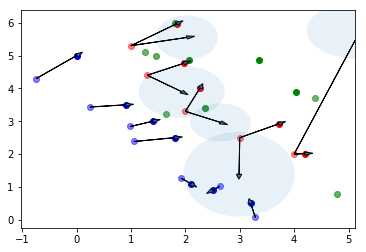

In [80]:
show_vb(enemy_point0, enemy1, res)

In [81]:
def init_reset():
    # 最干脆的方法当然是整个动态图全部重建，但目前框架的缺陷使得这么做要写很多global,nonlocal或者写个奇怪的闭包函数
    #（面向对象每次引入名字就更蠢了），所以做个值初始化比较方便。
    enemy1.data = torch.from_numpy(enemy_point0.copy())

In [82]:
init_reset()

In [83]:
res = vb(target)
res

(array([1.38326682, 5.16555971, 1.53730363, 4.35203528, 2.21570446,
        3.25435904, 3.25181632, 2.97179607, 4.14445956, 2.19864803]),
 array([0.28419033, 0.34768946, 0.60394982, 0.75422769, 0.36441886,
        0.44843932, 0.49090309, 0.46591269, 0.67604049, 1.63677622]))

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


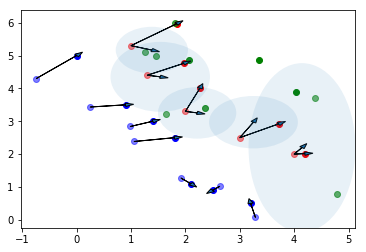

In [84]:
show_vb(enemy_point0, enemy1, res)

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


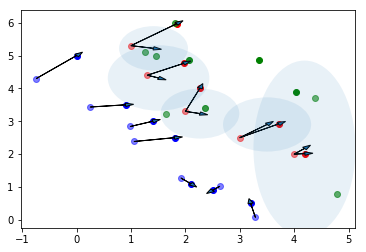

In [85]:
init_reset()
res = vb(target)
show_vb(enemy_point0, enemy1, res)

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


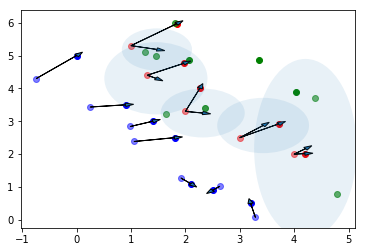

In [86]:
init_reset()
res = vb(target)
show_vb(enemy_point0, enemy1, res)

In [87]:
res

(array([1.47639788, 5.18440506, 1.45761678, 4.30660583, 2.31793014,
        3.24983172, 3.42965571, 2.87093623, 4.20773206, 2.1635506 ]),
 array([0.25531725, 0.24869183, 0.64008451, 0.7876909 , 0.43582413,
        0.39636288, 0.52407783, 0.51998704, 0.63491167, 1.69831037]))